In [2]:
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt

import random
import itertools
from copy import deepcopy

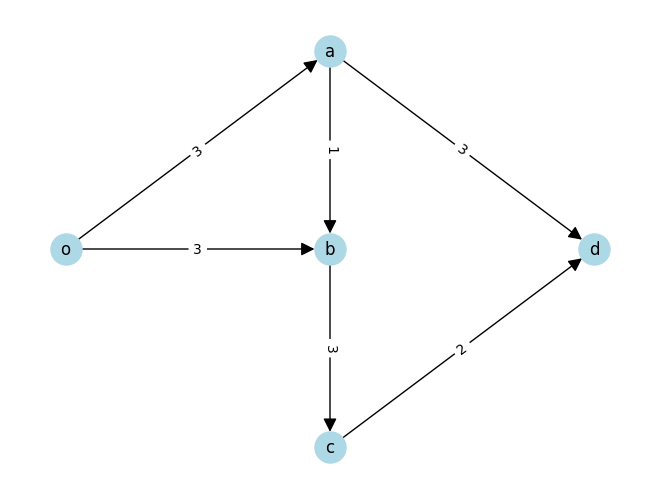

In [3]:
# Graph creation
G = nx.DiGraph()

nodes = ['o', 'a', 'b', 'c', 'd']
G.add_nodes_from(nodes)

edges = [
    ('o', 'a', {'capacity': 3}),
    ('a', 'd', {'capacity': 3}),
    ('o', 'b', {'capacity': 3}),
    ('b', 'c', {'capacity': 3}),
    ('c', 'd', {'capacity': 2}),
    ('a', 'b', {'capacity': 1}),
]
G.add_edges_from(edges)

pos = {
    'o': (0, 0),    # Left center
    'a': (1, 1),    # Top middle-left
    'b': (1, 0),    # Center
    'c': (1, -1),   # Bottom middle-right
    'd': (2, 0)     # Top right
}

def draw_capacited_graph(G, pos=pos):
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=500, arrowsize=20)

    edge_labels = nx.get_edge_attributes(G, 'capacity')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

draw_capacited_graph(G)

# (a) Capacity of Cuts and Minimum Removal
**Question:** Compute the capacity of all the cuts and find the minimum capacity to be removed for no
feasible flow from $o$ to $d$ to exist.


**Answer:** Considering the small size of the graph, all cut capacities have been computed manually. The complete list of cuts and their corresponding capacities is report in the Report. To validate our results, we also verified the minimum cut and the maximum throughput using the NetworkX functions: `networkx.algorithms.flow.minimum_cut` and `networkx.algorithms.flow.maximum_flow`

In [4]:
# Minimum cut
nx.algorithms.flow.minimum_cut(G,'o','d')

(5, ({'a', 'b', 'c', 'o'}, {'d'}))

In [5]:
# Maximum throughput
nx.algorithms.flow.maximum_flow(G,'o','d')

(5,
 {'o': {'a': 3, 'b': 2},
  'a': {'d': 3, 'b': 0},
  'b': {'c': 2},
  'c': {'d': 2},
  'd': {}})

# (b) Capacity Augmentation for Maximum Throughput
**Question:** You are given $x > 0$ extra units of capacity $x \in Z$. How should you distribute them in order to maximize the throughput that can be sent from $o$ to $d$?
Plot the maximum throughput from $o$ to $d$ as a function of $x \ge 0$


**Answer:** We adopted an incremental allocation approach that's well explained in the Report.

[x=0] max throughput = 5
[x=1] min-cut=5  +1 on ('c', 'd')  -> max throughput = 6
[x=2] min-cut=6  +1 on ('o', 'a')  -> max throughput = 6
[x=3] min-cut=6  +1 on ('a', 'd')  -> max throughput = 7
[x=4] min-cut=7  +1 on ('o', 'a')  -> max throughput = 7
[x=5] min-cut=7  +1 on ('a', 'd')  -> max throughput = 8
[x=6] min-cut=8  +1 on ('o', 'a')  -> max throughput = 8
[x=7] min-cut=8  +1 on ('a', 'd')  -> max throughput = 9
[x=8] min-cut=9  +1 on ('o', 'a')  -> max throughput = 9
[x=9] min-cut=9  +1 on ('a', 'd')  -> max throughput = 10
[x=10] min-cut=10  +1 on ('o', 'a')  -> max throughput = 10
[x=11] min-cut=10  +1 on ('a', 'd')  -> max throughput = 11
[x=12] min-cut=11  +1 on ('o', 'a')  -> max throughput = 11
[x=13] min-cut=11  +1 on ('a', 'd')  -> max throughput = 12
[x=14] min-cut=12  +1 on ('o', 'a')  -> max throughput = 12
[x=15] min-cut=12  +1 on ('a', 'd')  -> max throughput = 13
[x=16] min-cut=13  +1 on ('o', 'a')  -> max throughput = 13
[x=17] min-cut=13  +1 on ('a', 'd')  -> m

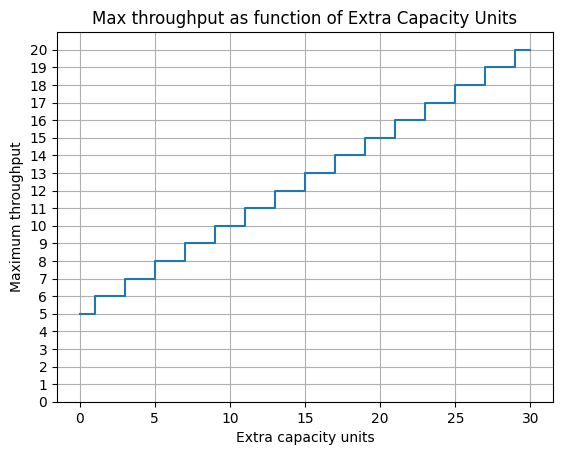

In [9]:
def cut_capacity_and_edges(G: nx.DiGraph, U: set, cap: str = 'capacity'):
    """Return the total capacity and edge list for the cut (U, V\\U)."""
    T = set(G.nodes()) - U
    cap_sum = 0
    cut_edges = []
    for u in U:
        for v in G.successors(u):
            if v in T:
                w = G[u][v].get(cap, 0)
                cap_sum += w
                cut_edges.append((u, v))
    return cap_sum, tuple(cut_edges)

def enumerate_valid_cuts(G: nx.DiGraph, s, t, cap: str = 'capacity'):
    """
    Generate all node subsets U that represent valid s–t cuts.
    A cut is valid if:
        (1) s ∈ U
        (2) t ∉ U
        (3) every node in U is reachable from s using only nodes in U
    """
    nodes = list(G.nodes())
    nodes.remove(s)
    if t in nodes:
        nodes.remove(t)

    valid_cuts = []
    # Generate all combinations of remaining nodes
    for r in range(len(nodes) + 1):
        for subset in itertools.combinations(nodes, r):
            U = set(subset) | {s}
            if t in U:
                continue
            # Condition check: internal reachability closure
            # if not is_internal_reachable_set(G, U, s):
                # continue  # Skip illegal combinations (missing intermediates)
            cap_sum, edges = cut_capacity_and_edges(G, U, cap=cap)
            valid_cuts.append({'U': U, 'cap': cap_sum, 'edges': edges})
    return valid_cuts

# ===============================================================
# (6) Functions for part 1.B – Incremental capacity allocation
# ---------------------------------------------------------------
# Goal:
#   Implement the logic for question 1.B:
#   "You are given x > 0 extra units of capacity (x ∈ Z). How should you distribute them
#    in order to maximize the throughput that can be sent from o to d?"
#
# Logic:
#   For each incremental unit (1..x):
#     1) Compute all minimum cuts using your existing functions.
#     2) If all min-cuts share common edges → increase one of those common edges.
#     3) Otherwise → increase the edge that appears in the highest number of min-cuts.
#        If there is still a tie, choose randomly among them.
#     4) After each increment, compute the new max flow and record it.
# ===============================================================

# ---------------------------------------------------------------
# Utility: find min-cuts using existing enumerate_valid_cuts()
# ---------------------------------------------------------------
def find_min_cuts(G: nx.DiGraph, s, t, cap: str = 'capacity'):
    cuts = enumerate_valid_cuts(G, s, t, cap=cap)
    if not cuts:
        return None, []
    cuts.sort(key=lambda c: (c['cap'], sorted(c['U'])))
    min_cap = cuts[0]['cap']
    min_cuts = [c for c in cuts if c['cap'] == min_cap]
    return min_cap, min_cuts


# ---------------------------------------------------------------
# Count how often each edge appears in the list of min-cuts
# ---------------------------------------------------------------
def edge_frequency_in_cuts(min_cuts):
    freq = {}
    for c in min_cuts:
        for e in c['edges']:
            freq[e] = freq.get(e, 0) + 1
    return freq


# ---------------------------------------------------------------
# Choose the edge to increase according to the described rules
# ---------------------------------------------------------------
def choose_edge_to_increase(min_cuts, rng: random.Random | None = None):
    if not min_cuts:
        return None
    if rng is None:
        rng = random

    # 1) If all min-cuts share common edges → choose one of them
    edge_sets = [set(c['edges']) for c in min_cuts]
    common = set.intersection(*edge_sets) if edge_sets else set()
    if common:
        return rng.choice(sorted(list(common)))

    # 2) Otherwise choose the edge that appears in the most min-cuts
    freq = edge_frequency_in_cuts(min_cuts)
    if not freq:
        return None
    max_count = max(freq.values())
    candidates = [e for e, c in freq.items() if c == max_count]
    # 3) If tie, pick one randomly among the most frequent
    return rng.choice(sorted(candidates))


# ---------------------------------------------------------------
# Main allocation routine
# ---------------------------------------------------------------
def allocate_extra_capacity_iterative(
    G_in: nx.DiGraph, s, t, x: int, cap: str = 'capacity',
    seed: int | None = None, verbose: bool = True
):
    """
    Increment capacities one by one for x steps following the given logic.
    """
    G = deepcopy(G_in)
    rng = random.Random(seed) if seed is not None else random

    throughputs = []
    v0, _ = nx.maximum_flow(G, s, t, capacity=cap)
    throughputs.append(v0)
    if verbose:
        print(f"[x=0] max throughput = {v0}")

    history = []
    for i in range(1, x + 1):
        min_cap, min_cuts = find_min_cuts(G, s, t, cap=cap)
        edge = choose_edge_to_increase(min_cuts, rng=rng)
        if edge is None:
            history.append({'step': i, 'min_cap': min_cap, 'increased': None, 'flow': throughputs[-1]})
            if verbose:
                print(f"[x={i}] no edge to increase; flow stays {throughputs[-1]}")
            continue

        # increment the chosen edge
        u, v = edge
        G[u][v][cap] = G[u][v].get(cap, 0) + 1
        v_now, _ = nx.maximum_flow(G, s, t, capacity=cap)
        throughputs.append(v_now)
        history.append({'step': i, 'min_cap': min_cap, 'increased': (u, v), 'flow': v_now})

        if verbose:
            print(f"[x={i}] min-cut={min_cap}  +1 on {edge}  -> max throughput = {v_now}")

    return G, history, throughputs


# ---------------------------------------------------------------
# Plotting utility for F(x)
# ---------------------------------------------------------------
def plot_throughput(throughputs, title="Max throughput vs Extra capacity units"):
    xs = list(range(len(throughputs)))  # includes x=0
    plt.figure()
    plt.step(xs, throughputs, where='post')
    plt.xlabel("Extra capacity units")
    plt.ylabel("Maximum throughput")
    plt.title(title)
    plt.grid(True)

    # --- make y-axis start from 0 ---
    y_min = 0
    y_max = max(throughputs)
    plt.ylim(y_min, y_max + 1)
    plt.yticks(range(y_min, y_max + 1, 1))
    
    plt.show()


# ===============================================================
# (7) Run incremental capacity allocation directly on existing DG
# ---------------------------------------------------------------
# Using the graph DG previously defined in the earlier cell.
# ===============================================================

s, t = 'o', 'd'

# Number of extra capacity units to allocate
x = 30

# Run the iterative allocation procedure
G_final, history, F = allocate_extra_capacity_iterative(G, s, t, x=x, seed=42, verbose=True)

# Print evolution of capacity increments and max flow values
print("\nHistory of increments:")
for h in history:
    print(h)

# Plot F(x): maximum throughput vs extra capacity x
plot_throughput(F, title="Max throughput as function of Extra Capacity Units")

# (c) Adding a New Link $e_8$
**Question:** You are given the possibility of adding to the network a directed link $e_8$ with capacity $c_8 = 1$ and $x > 0$ extra units of capacity ($x \in Z$). Where should you add the link and how should you distribute the additional capacity in order to maximize the throughput that can be sent from $o$ to $d$? Plot the maximum throughput from $o$ to $d$ as a function of $x\ge0$.


**Answer:** ...

--- F_max(x) with e8 : o -> d ---
x =  0  ->  F_max(x) = 6
x =  1  ->  F_max(x) = 7
x =  2  ->  F_max(x) = 8
x =  3  ->  F_max(x) = 9
x =  4  ->  F_max(x) = 10
x =  5  ->  F_max(x) = 11
x =  6  ->  F_max(x) = 12
x =  7  ->  F_max(x) = 13
x =  8  ->  F_max(x) = 14
x =  9  ->  F_max(x) = 15
x = 10  ->  F_max(x) = 16
x = 11  ->  F_max(x) = 17
x = 12  ->  F_max(x) = 18
x = 13  ->  F_max(x) = 19
x = 14  ->  F_max(x) = 20
x = 15  ->  F_max(x) = 21
x = 16  ->  F_max(x) = 22
x = 17  ->  F_max(x) = 23
x = 18  ->  F_max(x) = 24
x = 19  ->  F_max(x) = 25
x = 20  ->  F_max(x) = 26
x = 21  ->  F_max(x) = 27
x = 22  ->  F_max(x) = 28
x = 23  ->  F_max(x) = 29
x = 24  ->  F_max(x) = 30
x = 25  ->  F_max(x) = 31
x = 26  ->  F_max(x) = 32
x = 27  ->  F_max(x) = 33
x = 28  ->  F_max(x) = 34
x = 29  ->  F_max(x) = 35
x = 30  ->  F_max(x) = 36


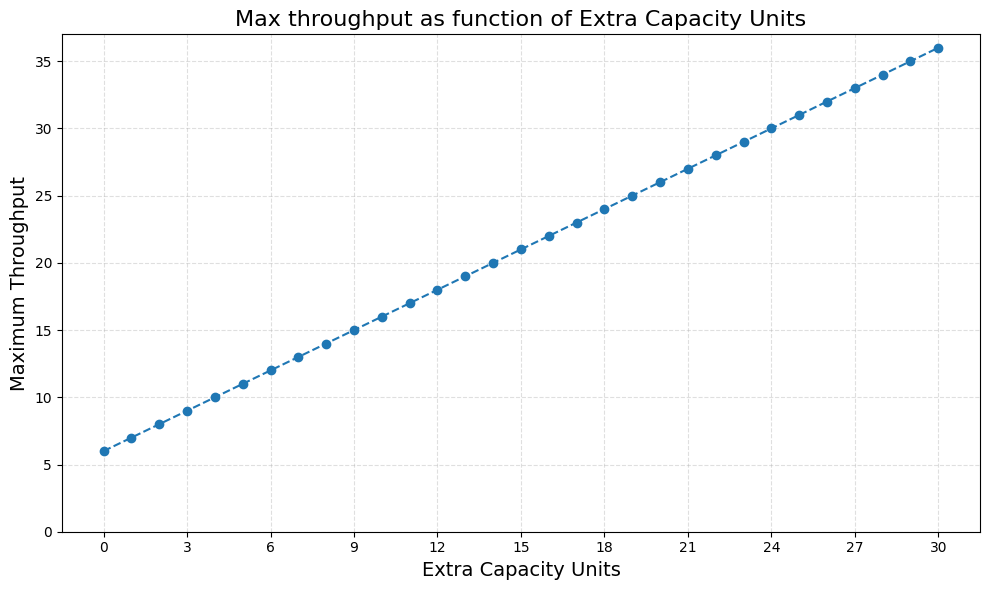

In [11]:
# ---------------------------------------------------------------
# (c) Adding e8: o -> d and allocating all extra capacity on e8
# ---------------------------------------------------------------

def compute_Fmax_linear_with_e8(G_base, X_max=30, c8_base=1):
    """
    Add a link e8: o -> d with base capacity c8_base.
    All extra units x are allocated on e8, so c8(x) = c8_base + x.

    Returns:
        x_values: [0, 1, ..., X_max]
        Fmax:    [F_max(0), ..., F_max(X_max)]
    """
    s, t = 'o', 'd'

    # Work on a copy of the base graph and add e8 with base capacity
    G0 = deepcopy(G_base)
    G0.add_edge('o', 'd', capacity=c8_base)

    # Compute F_max(0) once (should be 6 in this exercise)
    F0 = nx.maximum_flow_value(G0, s, t, capacity='capacity')

    x_values = list(range(X_max + 1))
    # By theory, each extra unit on e8 increases all cuts by 1
    Fmax = [F0 + x for x in x_values]

    return x_values, Fmax


def plot_Fmax_linear(x_values, Fmax):
    """
    Plot F_max(x) vs x as a straight dashed line,
    with fewer ticks on both axes.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, Fmax, marker='o', linestyle='--')

    plt.title (r"Max throughput as function of Extra Capacity Units", fontsize=16)
    plt.xlabel(r"Extra Capacity Units", fontsize=14)
    plt.ylabel(r"Maximum Throughput", fontsize=14)

    # --- X axis ticks: about every 2–3 units ---
    x_min, x_max = min(x_values), max(x_values)
    x_step = max(1, (x_max - x_min) // 10)   # ~10 ticks at most
    plt.xticks(range(x_min, x_max + 1, x_step))

    # --- Y axis ticks: about every 5 units ---
    y_min = 0
    y_max = max(Fmax)
    plt.ylim(y_min, y_max + 1)
    y_step = max(1, (y_max - y_min) // 7)    # ~7 ticks at most
    plt.yticks(range(y_min, y_max + 1, y_step))

    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# ----- run for point (c) -----
X_max = 30
x_vals_c, Fmax_c = compute_Fmax_linear_with_e8(G, X_max=X_max, c8_base=1)

# Optional: print to verify F_max(x) = 6 + x
print("--- F_max(x) with e8 : o -> d ---")
for x_val, f_val in zip(x_vals_c, Fmax_c):
    print(f"x = {x_val:2d}  ->  F_max(x) = {f_val}")

# Plot the linear relationship
plot_Fmax_linear(x_vals_c, Fmax_c)